In [2]:
import numpy as np
import pandas as pd
import re
import torch
import nltk
import scipy.sparse as sp
import tensorflow as tf

from joblib import dump, load
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.sparse import save_npz, load_npz
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from transformers import BertModel, BertTokenizer
from scipy.sparse import csr_matrix, hstack
import os

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balig\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# Training (Dataset 1)

## Dataset 1 Preprocessing

In [3]:
data = pd.read_csv('data.csv')
data.head()

,text,source,prompt_id,text_length,word_count
0,"Federal law supersedes state law, and cannabis...",Bloom-7B,0,967,157
1,Miles feels restless after working all day. He...,Bloom-7B,0,5068,778
2,So first of I am danish. That means that I fol...,Bloom-7B,0,1602,267
3,In this paper we present a novel rule-based ap...,Bloom-7B,0,5469,848
4,"Most social progressives, love democracy, and ...",Bloom-7B,0,2379,380


### Text Processing

In [4]:
def assign_value(source):
    if source == 'Human':
        return 0
    else:
        return 1

data['class'] = data['source'].apply(assign_value)

In [5]:
data.drop(columns=['source', 'prompt_id', 'text_length', 'word_count'], inplace=True)

In [6]:
def downsample_data(input_data, samples_to_keep):
    grouped_data = input_data.groupby('class', group_keys=False)

    downsampled_data = grouped_data.apply(lambda x: x if len(x) <= samples_to_keep else resample(x, replace=False, n_samples=samples_to_keep, random_state=42))

    downsampled_data = downsampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

    return downsampled_data

data = downsample_data(data, samples_to_keep=150000)

In [7]:
data['text'] = data['text'].apply(preprocess_text)

NameError: name 'preprocess_text' is not defined

### Numeric Processing

In [8]:
add_columns(data)

NameError: name 'add_columns' is not defined

In [9]:
scaler = StandardScaler()
data[['text_length', 'word_count']] = scaler.fit_transform(data[['text_length', 'word_count']])
dump(scaler, 'scaler.pkl')

KeyError: "None of [Index(['text_length', 'word_count'], dtype='object')] are in the [columns]"

### Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data[['text', 'text_length', 'word_count']], data['class'], test_size=0.2, random_state=42)

X_train[['text_length', 'word_count']] = X_train[['text_length', 'word_count']].astype(float)
X_test[['text_length', 'word_count']] = X_test[['text_length', 'word_count']].astype(float)

KeyError: "['text_length', 'word_count'] not in index"

## TFIDF

In [226]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf_text = tfidf_vectorizer.fit_transform(X_train['text'])
X_test_tfidf_text  = tfidf_vectorizer.transform(X_test['text'])
dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

In [ ]:
# Concatenate TF-IDF vectors with additional features
X_train_tfidf = sp.hstack([X_train_tfidf_text, X_train[['text_length', 'word_count']], format='csr')
X_test_tfidf = sp.hstack([X_test_tfidf_text, X_test[['text_length', 'word_count']]], format='csr')

## BERT

In [155]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [163]:
def get_bert_embeddings(texts):
    if isinstance(texts, pd.Series):
        texts = texts.tolist()

    all_embeddings = []

    batch_size = 32
    total_batches = (len(texts) + batch_size - 1) // batch_size
    print(f"Total batches to process: {total_batches}")
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
        all_embeddings.append(embeddings)

    # Concatenate all batch embeddings
    all_embeddings = np.vstack(all_embeddings)
    return all_embeddings

Warning - Running Cell below takes a while

In [ ]:
X_train_bert = get_bert_embeddings(X_train_texts)
X_test_bert = get_bert_embeddings(X_test_texts)

In [ ]:
X_train_bert = sp.hstack([X_train_bert, X_train[['text_length', 'word_count']].astype(float)], format='csr')
X_test_bert = sp.hstack([X_test_bert, X_test[['text_length', 'word_count']].astype(float)], format='csr')

## General Text Preprocessing

In [65]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing whitespaces
    text = text.strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    # Stemming
    stemmer = PorterStemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    text = ' '.join(stemmed_words)

    return text

## General Numeric Preprocessing

In [69]:
def add_columns(df):
    df['text_length'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))

## Model Training

### Random Forest

#### TFIDF

In [284]:
rf_model_tfidf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
rf_model_tfidf.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=20, random_state=0)

In [285]:
dump(rf_model_tfidf, 'rf_model_tfidf.joblib')

['rf_model_tfidf.joblib']

In [286]:
rf_tfidf_preds = rf_model_tfidf.predict(X_test_tfidf)

In [287]:
rf_tfidf_preds = np.where(rf_tfidf_preds > 0.5, 1, 0)

In [288]:
y_test = y_test.ravel()
rf_tfidf_preds = np.array(rf_tfidf_preds).ravel()

In [289]:
accuracy_tfidf_rf = accuracy_score(y_test, rf_tfidf_preds)
precision_tfidf_rf = precision_score(y_test, rf_tfidf_preds)
recall_tfidf_rf = recall_score(y_test, rf_tfidf_preds)
f1_tfidf_rf = f1_score(y_test, rf_tfidf_preds)

print("Accuracy:", accuracy_tfidf_rf)
print("Precision:", precision_tfidf_rf)
print("Recall:", recall_tfidf_rf)
print("F1 Score:", f1_tfidf_rf)


Accuracy: 0.7635166666666666
Precision: 0.7013982287410866
Recall: 0.9194331714456789
F1 Score: 0.7957506225798557


#### BERT

In [45]:
rf_model_bert = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
rf_model_bert.fit(X_train_bert, y_train)

C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=20, random_state=0)

In [46]:
dump(rf_model_bert, 'rf_model_bert.joblib')

['rf_model_bert.joblib']

In [47]:
rf_bert_preds = rf_model_bert.predict(X_test_bert)

In [48]:
rf_bert_preds = np.where(rf_bert_preds > 0.5, 1, 0)

In [51]:
y_test = y_test
rf_bert_preds = np.array(rf_bert_preds)

In [52]:
accuracy_bert_rf = accuracy_score(y_test, rf_bert_preds)
precision_bert_rf = precision_score(y_test, rf_bert_preds)
recall_bert_rf = recall_score(y_test, rf_bert_preds)
f1_bert_rf = f1_score(y_test, rf_bert_preds)

print("Accuracy:", accuracy_bert_rf)
print("Precision:", precision_bert_rf)
print("Recall:", recall_bert_rf)
print("F1 Score:", f1_bert_rf)

Accuracy: 0.7902833333333333
Precision: 0.7681403982450219
Recall: 0.8328121881445013
F1 Score: 0.7991700582555263


### SVM

#### TFIDF

In [67]:
svm_model_tfidf = SVC(kernel='rbf',random_state=42, max_iter=1000, verbose=True)
svm_model_tfidf.fit(X_train_tfidf, y_train)

[LibSVM]

C:\Users\westi\anaconda3\envs\older\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(max_iter=1000, random_state=42, verbose=True)

In [68]:
dump(svm_model_tfidf, 'svm_model_tfidf.joblib')

['svm_model_tfidf.joblib']

In [242]:
print(X_test_tfidf[0])

  (0, 16464)	0.5027639261302966
  (0, 17659)	0.29074816684077925
  (0, 25311)	0.13787124996831074
  (0, 43445)	0.18024284281490283
  (0, 57725)	0.14463166027848906
  (0, 85501)	0.1056695350486355
  (0, 128186)	0.1905665844163638
  (0, 211380)	0.1114984485542684
  (0, 219652)	0.29613586193097946
  (0, 226814)	0.13988443434683495
  (0, 235037)	0.07946553374045048
  (0, 236141)	0.1232824730162694
  (0, 279911)	0.4673877307285569
  (0, 368365)	0.12448826775138222
  (0, 373273)	0.2979017984227457
  (0, 389616)	0.1664435826631271
  (0, 392582)	0.15423518662500413
  (0, 414302)	0.13365885034682218
  (0, 437568)	0.09766211068199172
  (0, 447593)	-0.6014993587351756
  (0, 447594)	-0.6388289418198279


In [69]:
svm_tfidf_preds = svm_model_tfidf.predict(X_test_tfidf)

In [70]:
accuracy_tfidf_svm = accuracy_score(y_test, svm_tfidf_preds)
precision_tfidf_svm = precision_score(y_test, svm_tfidf_preds)
recall_tfidf_svm = recall_score(y_test, svm_tfidf_preds)
f1_tfidf_svm = f1_score(y_test, svm_tfidf_preds)

print("Accuracy:", accuracy_tfidf_svm)
print(1"Precision:", precision_tfidf_svm)
print("Recall:", recall_tfidf_svm)
print("F1 Score:", f1_tfidf_svm)

Accuracy: 0.71745
Precision: 0.6732665415422031
Recall: 0.8472157541081764
F1 Score: 0.7502909074840554


#### BERT

In [36]:
svm_model_bert = SVC(kernel='rbf', random_state=42, max_iter=1000, verbose=True)
svm_model_bert.fit(X_train_bert, y_train)

C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibSVM]

C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(max_iter=1000, random_state=42, verbose=True)

In [37]:
dump(svm_model_bert, 'svm_model_bert.joblib')

['svm_model_bert.joblib']

In [38]:
svm_bert_preds = svm_model_bert.predict(X_test_bert)

In [39]:
accuracy_bert_svm = accuracy_score(y_test, svm_bert_preds)
precision_bert_svm = precision_score(y_test, svm_bert_preds)
recall_bert_svm = recall_score(y_test, svm_bert_preds)
f1_bert_svm = f1_score(y_test, svm_bert_preds)

print("Accuracy:", accuracy_bert_svm)
print("Precision:", precision_bert_svm)
print("Recall:", recall_bert_svm)
print("F1 Score:", f1_bert_svm)

Accuracy: 0.50085
Precision: 0.5009513866671157
Recall: 0.9896214490053888
F1 Score: 0.6651835123925365


### LR

#### TFIDF

In [35]:
lg_model_tfidf = LogisticRegression(random_state=42, max_iter=1000)
lg_model_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [36]:
dump(lg_model_tfidf, 'lg_model_tfidf.joblib')

['lg_model_tfidf.joblib']

In [37]:
lr_tfidf_pred = lg_model_tfidf.predict(X_test_tfidf)

In [38]:
lr_tfidf_pred = lr_tfidf_pred.astype(np.int64)
y_test = y_test.astype(np.int64)

In [39]:
accuracy_tfidf_lr = accuracy_score(y_test, lr_tfidf_pred)
precision_tfidf_lr = precision_score(y_test, lr_tfidf_pred)
recall_tfidf_lr = recall_score(y_test, lr_tfidf_pred)
f1_tfidf_lr = f1_score(y_test, lr_tfidf_pred)

print("Accuracy:", accuracy_tfidf_lr)
print("Precision:", precision_tfidf_lr)
print("Recall:", recall_tfidf_lr)
print("F1 Score:", f1_tfidf_lr)

Accuracy: 0.8535166666666667
Precision: 0.8442567239537819
Recall: 0.8677067394052292
F1 Score: 0.8558211256746338


#### BERT

In [40]:
lg_model_bert = LogisticRegression(random_state=42, max_iter=1000)
lg_model_bert.fit(X_train_bert, y_train)

C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000, random_state=42)

In [41]:
dump(lg_model_bert, 'lg_model_bert.joblib')

['lg_model_bert.joblib']

In [42]:
lr_bert_pred = lg_model_bert.predict(X_test_bert)

In [43]:
lr_bert_pred = lr_bert_pred.astype(np.int64)
y_test = y_test.astype(np.int64)

In [44]:
accuracy_bert_lr = accuracy_score(y_test, lr_bert_pred)
precision_bert_lr = precision_score(y_test, lr_bert_pred)
recall_bert_lr = recall_score(y_test, lr_bert_pred)
f1_bert_lr = f1_score(y_test, lr_bert_pred)

print("Accuracy:", accuracy_bert_lr)
print("Precision:", precision_bert_lr)
print("Recall:", recall_bert_lr)
print("F1 Score:", f1_bert_lr)

Accuracy: 0.7813
Precision: 0.7803893008474576
Recall: 0.7841793626505222
F1 Score: 0.7822797411647586


### NN

#### TFIDF

In [76]:
# input layer
tfidf_input = Input(shape=(X_train_tfidf.shape[1],), name='tfidf_input')

# layers
tfidf_dense = Dense(64, activation='tanh')(tfidf_input)
tfidf_dense = Dropout(0.15)(tfidf_dense)

# layer
tfidf_output = Dense(1, activation='sigmoid')(tfidf_dense)

# Create the model
nn_model_tfidf = Model(inputs=tfidf_input, outputs=tfidf_output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
nn_model_tfidf.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [77]:
# Train
tfidf_history = nn_model_tfidf.fit(X_train_tfidf, y_train, batch_size=32, epochs=5, validation_data=(X_test_tfidf, y_test))

Epoch 1/5


C:\Users\westi\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/dense_4/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/dense_4/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/dense_4/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


7500/7500 [==============================] - 1636s 218ms/step - loss: 0.1091 - accuracy: 0.8428 - val_loss: 0.0949 - val_accuracy: 0.8657
Epoch 2/5
7500/7500 [==============================] - 1654s 221ms/step - loss: 0.0759 - accuracy: 0.8965 - val_loss: 0.0946 - val_accuracy: 0.8689
Epoch 3/5
7500/7500 [==============================] - 1660s 221ms/step - loss: 0.0641 - accuracy: 0.9143 - val_loss: 0.0964 - val_accuracy: 0.8680
Epoch 4/5
7500/7500 [==============================] - 1710s 228ms/step - loss: 0.0569 - accuracy: 0.9250 - val_loss: 0.0991 - val_accuracy: 0.8670
Epoch 5/5
7500/7500 [==============================] - 1700s 227ms/step - loss: 0.0519 - accuracy: 0.9320 - val_loss: 0.1005 - val_accuracy: 0.8651


In [121]:
nn_model_tfidf.save('nn_model_tfidf.keras')

In [135]:
absolute_path = os.path.abspath('nn_model_tfidf.keras')
print(absolute_path)
nn_model_tfidf = tf.keras.models.load_model(absolute_path)

C:\Users\westi\OneDrive\Documents\GitHub\RIT\ML_Project\nn_model_tfidf.keras


In [123]:
# Evaluate
nn_tfidf_pred = nn_model_tfidf.predict(X_test_tfidf)

nn_tfidf_pred = np.where(nn_tfidf_pred > 0.5, 1, 0)

accuracy_tfidf_nn = accuracy_score(y_test, nn_tfidf_pred)
precision_tfidf_nn = precision_score(y_test, nn_tfidf_pred)
recall_tfidf_nn = recall_score(y_test, nn_tfidf_pred)
f1_tfidf_nn = f1_score(y_test, nn_tfidf_pred)

print("Accuracy:", accuracy_bert_lr)
print("Precision:", precision_bert_lr)
print("Recall:", recall_bert_lr)
print("F1 Score:", f1_bert_lr)

1875/1875 [==============================] - 4s 2ms/step
Accuracy: 0.7721666666666667
Precision: 0.7775294595692808
Recall: 0.7638214356995543
F1 Score: 0.7706144913917509


#### BERT

In [11]:
import os

In [26]:
# input layer
bert_input = Input(shape=(X_train_bert.shape[1],), name='bert_input')

# layers
bert_dense = Dense(64, activation='tanh')(bert_input)
bert_dense = Dropout(0.15)(bert_dense)

# layer
bert_output = Dense(1, activation='sigmoid')(bert_dense)

# Create the model
nn_model_bert = Model(inputs=bert_input, outputs=bert_output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
nn_model_bert.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [28]:
X_train_bert = X_train_bert.astype('float64')
X_test_bert = X_test_bert.astype('float64')
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [29]:
# Train
bert_history = nn_model_bert.fit(X_train_bert, y_train, batch_size=32, epochs=5, validation_data=(X_test_bert, y_test))

Epoch 1/5
7500/7500 [==============================] - 11s 1ms/step - loss: 0.1500 - accuracy: 0.7756 - val_loss: 0.1298 - val_accuracy: 0.8100
Epoch 2/5
7500/7500 [==============================] - 10s 1ms/step - loss: 0.1287 - accuracy: 0.8117 - val_loss: 0.1178 - val_accuracy: 0.8284
Epoch 3/5
7500/7500 [==============================] - 11s 1ms/step - loss: 0.1215 - accuracy: 0.8233 - val_loss: 0.1184 - val_accuracy: 0.8285
Epoch 4/5
7500/7500 [==============================] - 10s 1ms/step - loss: 0.1175 - accuracy: 0.8293 - val_loss: 0.1097 - val_accuracy: 0.8421
Epoch 5/5
7500/7500 [==============================] - 10s 1ms/step - loss: 0.1148 - accuracy: 0.8345 - val_loss: 0.1115 - val_accuracy: 0.8392


In [30]:
nn_model_bert.save('nn_model_bert.keras')


In [152]:
absolute_path = os.path.abspath('nn_model_bert.keras')
nn_model_bert = tf.keras.models.load_model(absolute_path)


In [32]:
nn_bert_pred = nn_model_bert.predict(X_test_bert)

1875/1875 [==============================] - 1s 687us/step


In [33]:
nn_bert_pred = np.where(nn_bert_pred > 0.5, 1, 0)

In [35]:
accuracy_bert_nn = accuracy_score(y_test, nn_bert_pred)
precision_bert_nn = precision_score(y_test, nn_bert_pred)
recall_bert_nn = recall_score(y_test, nn_bert_pred)
f1_bert_nn = f1_score(y_test, nn_bert_pred)

print("Accuracy:", accuracy_bert_nn)
print("Precision:", precision_bert_nn)
print("Recall:", recall_bert_nn)
print("F1 Score:", f1_bert_nn)

Accuracy: 0.8391666666666666
Precision: 0.8542519958347796
Recall: 0.8186747388729958
F1 Score: 0.8360850659056938


# Dataset 2

In [172]:
data2 = pd.read_csv('data2.csv')
data2 = data2.sample(frac=1).reset_index(drop=True)
data2 = data2[:9999]
data2.head()

,text,generated
0,There's a Face on Mar's that some people threo...,0.0
1,Social media has become an integral part of ou...,1.0
2,My dream jot was to Become a scientist. I fina...,0.0
3,There are many advantages to limiting car usag...,0.0
4,Making Mona Lisa Smile: A Breakthrough that Ca...,1.0


In [173]:
def change_generated(_class):
    if _class == 1.0:
        return 1
    else:
        return 0

data2['class'] = data2['generated'].apply(change_generated)

In [174]:
data2.drop(columns=['generated'], inplace=True)

In [175]:
data2['text'] = data2['text'].apply(preprocess_text)

In [176]:
add_columns(data2)

In [177]:
scaler = load('scaler.pkl')

C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [178]:
data2[['text_length', 'word_count']] = scaler.transform(data2[['text_length', 'word_count']])

In [179]:
data2_bert = data2.copy(deep=True)

In [142]:
data2 = data2[['text', 'text_length', 'word_count', 'class']]

### TFIDF

In [143]:
tfidf_vectorizer = load('tfidf_vectorizer.pkl')

C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [144]:
data2['text'] = data2['text'].apply(lambda x: tfidf_vectorizer.transform([x]))

In [145]:
additional_features = csr_matrix(data2[['text_length', 'word_count']])

In [146]:
all_vector = [hstack([text_row, additional_features[idx]]) for idx, text_row in enumerate(data2['text'])]

In [147]:
rf_model_tfidf = load('rf_model_tfidf.joblib')
svm_model_tfidf = load('svm_model_tfidf.joblib')
lg_model_tfidf = load('lg_model_tfidf.joblib')
absolute_path = os.path.abspath('nn_model_tfidf.keras')
nn_model_tfidf = tf.keras.models.load_model(absolute_path)

C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\westi\anaconda3\envs\even_older\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.4.2 

In [148]:
rf_predictions = []
lg_predictions = []
svm_predictions = []
nn_predictions = []
ensemble_predictions = []
actual_values = []

In [149]:
for vector in range(len(all_vector)):
    rf_tfidf_pred = rf_model_tfidf.predict(all_vector[vector])
    lg_tfidf_pred = lg_model_tfidf.predict(all_vector[vector])
    svm_tfidf_pred = svm_model_tfidf.predict(all_vector[vector])
    nn_tfidf_pred = nn_model_tfidf.predict(all_vector[vector], verbose=0)
    nn_tfidf_pred = np.where(nn_tfidf_pred > 0.5, 1, 0)
    if lg_tfidf_pred + svm_tfidf_pred + nn_tfidf_pred + rf_tfidf_pred > 2:
        ensemble = 1
    else:
        ensemble = 0

    rf_predictions.append(rf_tfidf_pred)
    lg_predictions.append(lg_tfidf_pred)
    svm_predictions.append(svm_tfidf_pred)
    nn_predictions.append(nn_tfidf_pred)
    ensemble_predictions.append(ensemble)
    actual_values.append(data2['class'][vector])

In [150]:
rf_predictions = np.array(rf_predictions)
lg_predictions = np.array(lg_predictions)
svm_predictions = np.array(svm_predictions)
nn_predictions = np.array(nn_predictions)
ensemble_predictions = np.array(ensemble_predictions)
actual_values = np.array(actual_values)

rf_predictions = rf_predictions.ravel()
lg_predictions = lg_predictions.ravel()
svm_predictions = svm_predictions.ravel()
nn_predictions = nn_predictions.ravel()
ensemble_predictions = ensemble_predictions.ravel()

In [151]:
def calculate_metrics(predictions, actual):
    accuracy = accuracy_score(actual, predictions)
    recall = recall_score(actual, predictions, zero_division=1)
    precision = precision_score(actual, predictions, zero_division=1)
    f1 = f1_score(actual, predictions, zero_division=1)
    return accuracy, recall, precision, f1

metrics_rf = calculate_metrics(rf_predictions, actual_values)
metrics_lg = calculate_metrics(lg_predictions, actual_values)
metrics_svm = calculate_metrics(svm_predictions, actual_values)
metrics_nn = calculate_metrics(nn_predictions, actual_values)
metrics_ensemble = calculate_metrics(ensemble_predictions, actual_values)

print("Random Forest Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_rf))
print("Logistic Regression Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_lg))
print("SVM Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_svm))
print("Neural Network Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_nn))
print("Ensemble Model Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_ensemble))

Random Forest Metrics: Accuracy=0.8108810881088109, Recall=0.94556181281845, Precision=0.6762562332182586, F1=0.7885497036788551
Logistic Regression Metrics: Accuracy=0.9280928092809281, Recall=0.9278626977742022, Precision=0.8849104859335039, F1=0.9058777326875246
SVM Metrics: Accuracy=0.6169616961696169, Recall=0.9774738535800482, Precision=0.49316736571505887, F1=0.6555755395683454
Neural Network Metrics: Accuracy=0.8574857485748575, Recall=0.88710109949048, Precision=0.7671614100185529, F1=0.8227832359159308
Ensemble Model Metrics: Accuracy=0.9187918791879188, Recall=0.9396621078037007, Precision=0.8565142996822293, F1=0.8961636828644501


### BERT

In [180]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [181]:
texts = data2_bert['text'].tolist()

['there face mar peopl threoris alien landmark howev there evid support natur landform face natur landform first pictur bluri second ten time sharper origin photo report natur landform scientist say mesa common western us state scientist say second photo ten time sharper origin photo mean accur articl show second pictur reader top third pictur right show look like natur landform one scientist jim garvin compar mesa mesa commonli found western area american west conclus face natur landform form mar said natur photo accur said pictur natur landform face cant martian relic mesa martian descent wouldnt look notic detail face natur landform first pictur shown mass bluri unaccur second sharper accur origin second photo report show natur landform scientist say face landform unsimilar mesa found western america',
 'social media becom integr part daili live ip impact societi topic much debat argu chap social media signific impact societ norm valu other believ chap ip impact limit opinion social

In [182]:
bert_text = get_bert_embeddings(texts)

Total batches to process: 313


100%|██████████| 313/313 [52:06<00:00,  9.99s/it]


In [185]:
additional_features = data2_bert[['text_length', 'word_count']].astype(float)

In [186]:
additional_features_sparse = sp.csr_matrix(additional_features)

In [187]:
bert_vector = sp.hstack([bert_text, additional_features_sparse], format='csr')

In [191]:
rf_model_bert = load('rf_model_bert.joblib')
svm_model_bert = load('svm_model_bert.joblib')
lg_model_bert = load('lg_model_bert.joblib')
absolute_path = os.path.abspath('nn_model_bert.keras')
nn_model_bert = tf.keras.models.load_model(absolute_path)

In [195]:
rf_predictions_bert = []
lg_predictions_bert = []
svm_predictions_bert = []
nn_predictions_bert = []
ensemble_predictions_bert = []
actual_values_bert = []

In [198]:
for vector in range(bert_vector.shape[0]):
    rf_bert_pred = rf_model_bert.predict(bert_vector[vector])

    vector_dense = bert_vector[vector].toarray()
    lg_bert_pred = svm_model_bert.predict(vector_dense)
    svm_bert_pred = lg_model_bert.predict(bert_vector[vector])
    nn_bert_pred = nn_model_bert.predict(bert_vector[vector], verbose=0)
    nn_bert_pred = np.where(nn_tfidf_pred > 0.5, 1, 0)
    if lg_bert_pred + svm_bert_pred + nn_bert_pred + rf_bert_pred > 2:
        ensemble_bert = 1
    else:
        ensemble_bert = 0

    rf_predictions_bert.append(rf_bert_pred)
    lg_predictions_bert.append(lg_bert_pred)
    svm_predictions_bert.append(svm_bert_pred)
    nn_predictions_bert.append(nn_bert_pred)
    ensemble_predictions_bert.append(ensemble_bert)
    actual_values_bert.append(data2['class'][vector])

In [199]:
rf_predictions_bert = np.array(rf_predictions_bert)
lg_predictions_bert = np.array(lg_predictions_bert)
svm_predictions_bert = np.array(svm_predictions_bert)
nn_predictions_bert = np.array(nn_predictions_bert)
ensemble_predictions_bert = np.array(ensemble_predictions_bert)
actual_values_bert = np.array(actual_values_bert)

rf_predictions_bert = rf_predictions_bert.ravel()
lg_predictions_bert = lg_predictions_bert.ravel()
svm_predictions_bert = svm_predictions_bert.ravel()
nn_predictions_bert = nn_predictions_bert.ravel()
ensemble_predictions_bert = ensemble_predictions_bert.ravel()

In [200]:
def calculate_metrics(predictions, actual):
    accuracy = accuracy_score(actual, predictions)
    recall = recall_score(actual, predictions, zero_division=1)
    precision = precision_score(actual, predictions, zero_division=1)
    f1 = f1_score(actual, predictions, zero_division=1)
    return accuracy, recall, precision, f1

metrics_rf_bert = calculate_metrics(rf_predictions_bert, actual_values_bert)
metrics_lg_bert = calculate_metrics(lg_predictions_bert, actual_values_bert)
metrics_svm_bert = calculate_metrics(svm_predictions_bert, actual_values_bert)
metrics_nn_bert = calculate_metrics(nn_predictions_bert, actual_values_bert)
metrics_ensemble_bert = calculate_metrics(ensemble_predictions_bert, actual_values_bert)

print("Random Forest Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_rf_bert))
print("Logistic Regression Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_lg_bert))
print("SVM Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_svm_bert))
print("Neural Network Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_nn_bert))
print("Ensemble Model Metrics: Accuracy={}, Recall={}, Precision={}, F1={}".format(*metrics_ensemble_bert))

Random Forest Metrics: Accuracy=0.862986298629863, Recall=0.7982480153298659, Precision=0.8216398985629755, F1=0.8097750624826439
Logistic Regression Metrics: Accuracy=0.3653365336533653, Recall=0.9997262523952916, Precision=0.36530959287786335, F1=0.5350915750915751
SVM Metrics: Accuracy=0.7195719571957195, Recall=0.8883109772789488, Precision=0.5752526147846126, F1=0.6982999784807403
Neural Network Metrics: Accuracy=0.6346634663466346, Recall=0.0, Precision=1.0, F1=0.0
Ensemble Model Metrics: Accuracy=0.8658865886588659, Recall=0.7582808650424309, Precision=0.8581164807930607, F1=0.805115535532626


# Demo

In [354]:
input_text = "Dogma, in its broadest sense, is any belief held unquestioningly and with undefended certainty. It may be in the form of an official system of principles or doctrines of a religion, such as Judaism, Roman Catholicism, Protestantism,[1] or Islam, as well as the positions of a philosopher or of a philosophical school, such as Stoicism."

In [355]:
demo_df = pd.DataFrame({'text': [input_text]})
demo_df['text'] = demo_df['text'].apply(preprocess_text)
add_columns(demo_df)
scaler = load('scaler.pkl')
demo_df[['text_length', 'word_count']] = scaler.fit_transform(demo_df[['text_length', 'word_count']])
tfidf_demo = demo_df.copy(deep=True)
bert_demo = demo_df.copy(deep=True)

In [356]:
# TFIDF
tfidf_vectorizer = load('tfidf_vectorizer.pkl')
tfidf_demo['text'] = tfidf_demo['text'].apply(lambda x: tfidf_vectorizer.transform([x]))
additional_features = csr_matrix(tfidf_demo[['text_length', 'word_count']])
vector = [hstack([text_row, additional_features[idx]]) for idx, text_row in enumerate(tfidf_demo['text'])]

rf_tfidf_pred, lg_tfidf_pred, svm_tfidf_pred, nn_tfidf_pred, ensemble = predict_tfidf(vector)

In [357]:
# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

demo_text = bert_demo['text'].tolist()

bert_text = get_bert_embeddings(demo_text)
additional_features = bert_demo[['text_length', 'word_count']].astype(float)
additional_features_sparse = sp.csr_matrix(additional_features)
bert_vector = sp.hstack([bert_text, additional_features_sparse], format='csr')

rf_bert_pred, lg_bert_pred, svm_bert_pred, nn_bert_pred, ensemble_bert = predict_bert(bert_vector)

Total batches to process: 1


100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


In [ ]:
print('0 - Human, 1 - AI\n')

print("TFIDF")
print(f"Random Forest: {rf_tfidf_pred}")
print(f"Linear Regression: {lg_tfidf_pred}")
print(f"Support Vector Machine: {svm_tfidf_pred}")
print(f"Neural Network: {nn_tfidf_pred}")
print(f"Ensemble: {ensemble}")
print("\n")
print("BERT")
print(f"Random Forest: {rf_bert_pred}")
print(f"Linear Regression: {lg_bert_pred}")
print(f"Support Vector Machine: {svm_bert_pred}")
print(f"Neural Network: {nn_bert_pred}")
print(f"Ensemble: {ensemble_bert}")

1 - Human, 0 - AI

TFIDF
Random Forest: [1]
Linear Regression: [1]
Support Vector Machine: [1]
Neural Network: [[1]]
Ensemble: 1


BERT
Random Forest: [1.]
Linear Regression: [1.]
Support Vector Machine: [0.]
Neural Network: [[1]]
Ensemble: 1


In [341]:
def predict_tfidf(vector):

        
    rf_tfidf_pred = rf_model_tfidf.predict(vector[0])
    lg_tfidf_pred = lg_model_tfidf.predict(vector[0])
    svm_tfidf_pred = svm_model_tfidf.predict(vector[0])
    nn_tfidf_pred = nn_model_tfidf.predict(vector[0], verbose=0)
    nn_tfidf_pred = np.where(nn_tfidf_pred > 0.5, 1, 0)
    if lg_tfidf_pred + svm_tfidf_pred + nn_tfidf_pred + rf_tfidf_pred > 2:
        ensemble = 1
    else:
        ensemble = 0
    return rf_tfidf_pred, lg_tfidf_pred, svm_tfidf_pred, nn_tfidf_pred, ensemble

In [342]:
rf_model_tfidf = load('rf_model_tfidf.joblib')
svm_model_tfidf = load('svm_model_tfidf.joblib')
lg_model_tfidf = load('lg_model_tfidf.joblib')
absolute_path = os.path.abspath('nn_model_tfidf.keras')
nn_model_tfidf = tf.keras.models.load_model(absolute_path)

In [343]:
def predict_bert(vector):
    rf_bert_pred = rf_model_bert.predict(vector[0])
    vector_dense = vector.toarray()
    lg_bert_pred = svm_model_bert.predict(vector_dense)
    svm_bert_pred = lg_model_bert.predict(vector[0])
    nn_bert_pred = nn_model_bert.predict(vector[0], verbose=0)
    nn_bert_pred = np.where(nn_tfidf_pred > 0.5, 1, 0)
    if lg_bert_pred + svm_bert_pred + nn_bert_pred + rf_bert_pred > 2:
        ensemble_bert = 1
    else:
        ensemble_bert = 0
    return rf_bert_pred, lg_bert_pred, svm_bert_pred, nn_bert_pred, ensemble_bert

In [344]:
rf_model_bert = load('rf_model_bert.joblib')
svm_model_bert = load('svm_model_bert.joblib')
lg_model_bert = load('lg_model_bert.joblib')
absolute_path = os.path.abspath('nn_model_bert.keras')
nn_model_bert = tf.keras.models.load_model(absolute_path)

In [324]:
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)


In [29]:
def process(row):
    
    if row['generated'] == 1.0:
        row['class'] = 1
    else:
        row['class'] = 0
        
    row['text'] = row['text'].lower()

    # Remove special characters and digits
    row['text'] = re.sub(r'[^a-zA-Z\s]', '', row['text'])

    # Remove extra whitespaces
    row['text'] = re.sub(r'\s+', ' ', row['text'])

    # Remove leading and trailing whitespaces
    row['text'] = row['text'].strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = row['text'].split()
    filtered_words = [word for word in words if word not in stop_words]
    row['text'] = ' '.join(filtered_words)

    # Stemming
    stemmer = PorterStemmer()
    words = row['text'].split()
    stemmed_words = [stemmer.stem(word) for word in words]
    row['text'] = ' '.join(stemmed_words)

    row['text_length'] = len(row['text'])
    row['word_count'] = len(words)

    extra_data = pd.DataFrame([row], columns=['text_length', 'word_count'])

    scaled_data = scaler.transform(extra_data)

    row[['text_length', 'word_count']] = scaled_data[0]

    texts = [row['text']]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    torch.cuda.empty_cache()  # Clear cache if on GPU

    if isinstance(texts, pd.Series):
        texts = texts.tolist()

    all_embeddings = []

    batch_size = 32
    total_batches = (len(texts) + batch_size - 1) // batch_size
    print(f"Total batches to process: {total_batches}")

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().detach().numpy()
        all_embeddings.append(embeddings)

        # Explicitly delete tensors to free up memory
        del inputs
        del outputs
        torch.cuda.empty_cache()  # Clear cache after processing each batch if on GPU

    all_embeddings = np.vstack(all_embeddings)
    
    print(all_embeddings)




    
    rf_tfidf_pred = rf_model_tfidf.predict(final_vector)
    
    lg_tfidf_pred = lg_model_tfidf.predict(final_vector)
    
    svm_tfidf_pred = svm_model_tfidf.predict(final_vector)
    
    nn_tfidf_pred = nn_model_tfidf.predict(final_vector, verbose=0)
    nn_tfidf_pred = np.where(nn_tfidf_pred > 0.5, 1, 0)

    # Tie goes to 0 (AI generated)
    if lg_tfidf_pred + svm_tfidf_pred + nn_tfidf_pred + rf_tfidf_pred > 2:
        ensemble = 1
    else:
        ensemble = 0

    print(f'RF: {rf_tfidf_pred}')
    print(f'LG: {lg_tfidf_pred}')
    print(f'SVM: {svm_tfidf_pred}')
    print(f'NN: {nn_tfidf_pred}')
    print(f'Ensemble: {ensemble}')
    print(f'Actual: {actual}')

    return rf_tfidf_pred, lg_tfidf_pred, svm_tfidf_pred, nn_tfidf_pred, ensemble, actual


rf_model_tfidf = load('rf_model_tfidf.joblib')
svm_model_tfidf = load('svm_model_tfidf.joblib')
lg_model_tfidf = load('lg_model_tfidf.joblib')
absolute_path = os.path.abspath('nn_model_tfidf.keras')
nn_model_tfidf = tf.keras.models.load_model(absolute_path)

scaler = load('scaler.pkl')
tfidf_vectorizer = load('tfidf_vectorizer.pkl')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [30]:
for index, row in tqdm(all_input_data.iterrows(), total=all_input_data.shape[0], desc="Processing rows"):
    
    rf_pred, lg_pred, svm_pred, nn_pred, ensemble_pred, actual = process(row)
    rf_predictions.append(rf_pred)
    lg_predictions.append(lg_pred)
    svm_predictions.append(svm_pred)
    nn_predictions.append(nn_pred)
    ensemble_predictions.append(ensemble_pred)
    actual_values.append(actual)

Processing rows:   0%|          | 0/1 [00:00<?, ?it/s]

Total batches to process: 1



Processing rows:   0%|          | 0/1 [00:00<?, ?it/s]

[[-4.67743963e-01  4.38333824e-02  1.67440444e-01 -1.06908590e-01
  -5.80246091e-01 -2.29067564e-01  3.66980135e-01  2.50282675e-01
  -2.75597125e-01 -3.68782878e-01  7.94676989e-02 -3.63638401e-01
   1.15250975e-01  7.07719177e-02 -5.63945413e-01 -2.07889378e-01
   2.46365950e-01  2.24262983e-01  7.39595294e-02  3.73365551e-01
  -1.24961019e-01 -6.45932913e-01  4.52246428e-01 -2.44033873e-01
   4.51694638e-01 -1.71674892e-01 -1.91663057e-01 -4.46048379e-02
   3.63581553e-02  2.45905221e-02  5.88150211e-02  4.36611325e-01
   2.74008572e-01 -5.21392345e-01  1.36571407e-01 -3.56311977e-01
   4.58211452e-01 -1.00919470e-01  5.02360106e-01  1.41305566e-01
  -1.18219167e-01  1.13352090e-01  7.96030015e-02 -3.17858070e-01
   1.90507233e-01  1.43471584e-02 -3.27742290e+00  2.56234020e-01
  -2.16225326e-01 -6.47995174e-01  2.00038329e-01 -3.54131252e-01
   3.20705995e-02  2.70668715e-01 -3.08918059e-01  3.29330891e-01
  -1.44676298e-01  7.58992285e-02  2.28468955e-01 -4.70163748e-02
   1.42051

NameError: name 'final_vector' is not defined

# Graphs

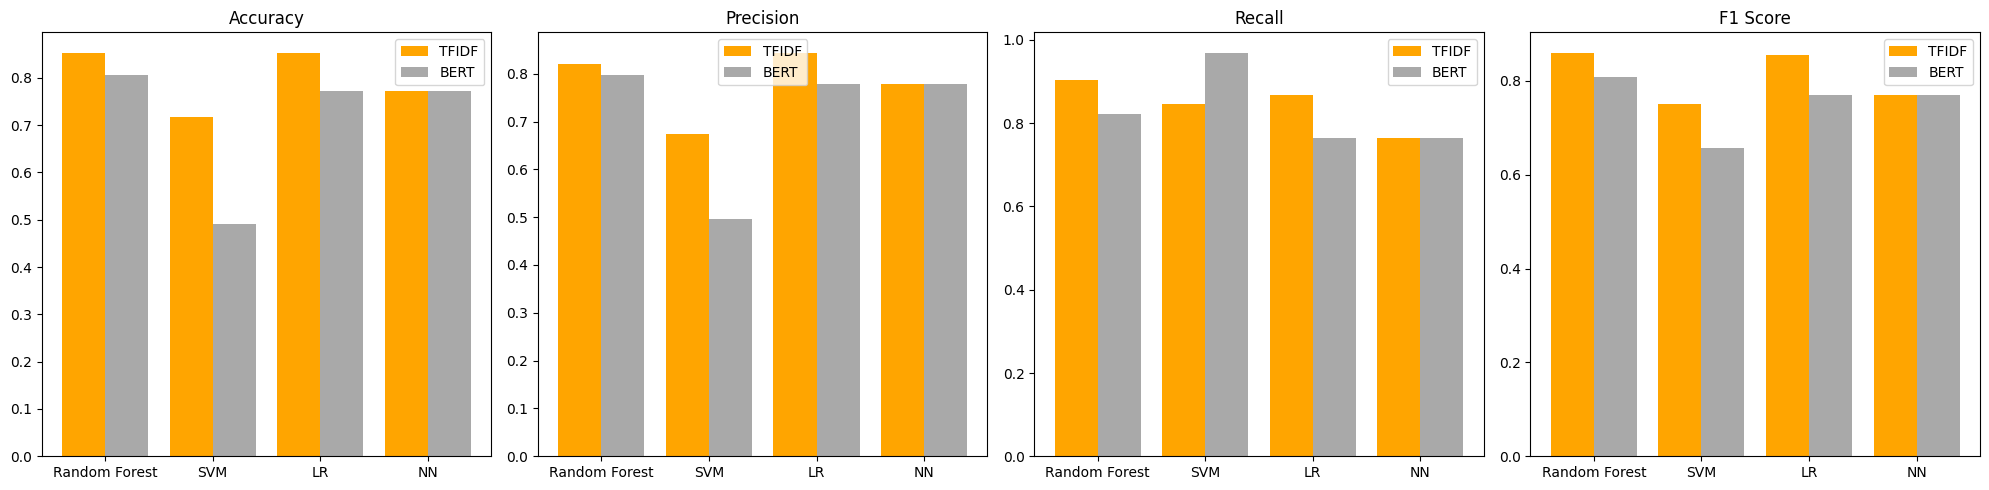

In [139]:
import matplotlib.pyplot as plt

models = ['Random Forest', 'SVM', 'LR', 'NN']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

tfidf_results = {
    'Random Forest': [0.8528833333333333, 0.8208188548119051, 0.9036324928481139, 0.8602371866934782],
    'SVM': [0.71745, 0.6732665415422031, 0.8472157541081764, 0.7502909074840554],
    'LR': [0.8535166666666667, 0.8442567239537819, 0.8677067394052292, 0.8558211256746338],
    'NN': [0.7721666666666667, 0.7775294595692808, 0.7638214356995543, 0.7706144913917509]
}

bert_results = {
    'Random Forest': [0.8057333333333333, 0.797120165299929, 0.8213026412081698, 0.8090307359591061],
    'SVM': [0.49118333333333336, 0.4960268168592285, 0.9696959616791964, 0.6563249316117121],
    'LR': [0.7721666666666667, 0.7775294595692808, 0.7638214356995543, 0.7706144913917509],
    'NN': [0.7721666666666667, 0.7775294595692808, 0.7638214356995543, 0.7706144913917509]
}

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, metric in enumerate(metrics):
    x = range(len(models))
    tfidf_values = [tfidf_results[model][i] for model in models]
    bert_values = [bert_results[model][i] for model in models]
    ax[i].bar([value - 0.2 for value in x], tfidf_values, width=0.4, label='TFIDF', color='orange')
    ax[i].bar([value + 0.2 for value in x], bert_values, width=0.4, label='BERT', color='darkgrey')
    ax[i].set_title(metric)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(models)
    ax[i].legend()

plt.tight_layout()
plt.show()

# Loading & Saving Variables

### Saves

In [ ]:
np.save('data_preprocessed.npy', data)
np.save('data_scaled.npy', data)

In [ ]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [ ]:
save_npz('X_train_tfidf.npz', X_train_tfidf)
save_npz('X_test_tfidf.npz', X_test_tfidf)

In [ ]:
np.save('X_train_bert.npy', X_train_bert)
np.save('X_test_bert.npy', X_test_bert)

### Load

In [16]:
X_train_bert = np.load('X_train_bert.npy')
X_test_bert = np.load('X_test_bert.npy')

In [4]:
X_train = np.load('X_train.npy', allow_pickle=True)
X_test = np.load('X_test.npy', allow_pickle=True)
y_train = np.load('y_train.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [ ]:
data_scaled = np.load('data_scaled.npy', allow_pickle=True)
data = pd.DataFrame(data_scaled, columns =['text', 'text_length', 'word_count', 'class'])

In [17]:
X_train = np.load('X_train.npy', allow_pickle=True)
X_test = np.load('X_test.npy', allow_pickle=True)
y_train = np.load('y_train.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)

X_train = pd.DataFrame(X_train, columns =['text', 'text_length', 'word_count'])
X_test = pd.DataFrame(X_test, columns =['text', 'text_length', 'word_count'])
y_train = pd.DataFrame(y_train, columns =['class'])
y_test = pd.DataFrame(y_test, columns =['class'])

In [ ]:
X_train_tfidf = load_npz('X_train_tfidf.npz')
X_test_tfidf = load_npz('X_test_tfidf.npz')

In [18]:
train_columns = X_train[['text_length', 'word_count']]
test_columns = X_test[['text_length', 'word_count']]

In [19]:
X_train_combined = np.concatenate([X_train_bert, train_columns], axis=1)
X_test_combined = np.concatenate([X_test_bert, test_columns], axis=1)

In [20]:
print(X_train_combined.shape)
print(X_test_combined.shape)

(240000, 770)
(60000, 770)


In [21]:
X_train_bert = X_train_combined
X_test_bert = X_test_combined

In [ ]:
X_train_bert = X_train_bert.astype('float64')
X_test_bert = X_test_bert.astype('float64')
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')